# 1. Import Dependencies

# 2. Implement data load functions

# 3. Make data pipeline

# 4. Design neural network

# 5. Setup training options

In [316]:
pip install opencv-python matplotlib imageio gdown tensorflow

Note: you may need to restart the kernel to use updated packages.


In [317]:
import os
import cv2
import tensorflow as tf
import numpy as np
from typing import List
from matplotlib import pyplot as plt
import imageio

In [318]:
tf.config.list_physical_devices('CPU')

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [319]:
physical_devices = tf.config.list_physical_devices('CPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0],True)
except:
    pass

In [320]:
import gdown

In [321]:
url = 'https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL'
output = 'data.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('data.zip')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL
From (redirected): https://drive.google.com/uc?id=1YlvpDLix3S-U8fd-gqRwPcWXAXm8JwjL&confirm=t&uuid=33df8f3d-4d19-4ecf-9242-a57193cefb37
To: /Users/daniel/data.zip
100%|████████████████████████████████████████| 423M/423M [01:27<00:00, 4.84MB/s]


['data/',
 'data/alignments/',
 'data/alignments/s1/',
 'data/alignments/s1/bbaf2n.align',
 'data/alignments/s1/bbaf3s.align',
 'data/alignments/s1/bbaf4p.align',
 'data/alignments/s1/bbaf5a.align',
 'data/alignments/s1/bbal6n.align',
 'data/alignments/s1/bbal7s.align',
 'data/alignments/s1/bbal8p.align',
 'data/alignments/s1/bbal9a.align',
 'data/alignments/s1/bbas1s.align',
 'data/alignments/s1/bbas2p.align',
 'data/alignments/s1/bbas3a.align',
 'data/alignments/s1/bbaszn.align',
 'data/alignments/s1/bbaz4n.align',
 'data/alignments/s1/bbaz5s.align',
 'data/alignments/s1/bbaz6p.align',
 'data/alignments/s1/bbaz7a.align',
 'data/alignments/s1/bbbf6n.align',
 'data/alignments/s1/bbbf7s.align',
 'data/alignments/s1/bbbf8p.align',
 'data/alignments/s1/bbbf9a.align',
 'data/alignments/s1/bbbm1s.align',
 'data/alignments/s1/bbbm2p.align',
 'data/alignments/s1/bbbm3a.align',
 'data/alignments/s1/bbbmzn.align',
 'data/alignments/s1/bbbs4n.align',
 'data/alignments/s1/bbbs5s.align',
 'data/al

In [322]:
def load_video(path:str) -> List[float]:
    
    cap = cv2.VideoCapture(path)
    frames = []
    for _ in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
        ret, frame = cap.read()
        frame = tf.image.rgb_to_grayscale(frame)
        frames.append(frame[190:236, 80:220,:])
    cap.release()
    
    mean = tf.math.reduce_mean(frames)
    std = tf.math.reduce_std(tf.cast(frames, tf.float32))
    return tf.cast((frames - mean), tf.float32) / std

In [323]:
vocab = [x for x in "abcdefghijklmnopqrstuvwxyz'?!123456789 "]

In [324]:
char_to_num = tf.keras.layers.StringLookup(vocabulary=vocab, oov_token="")
num_to_char = tf.keras.layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), oov_token="", invert=True
)

print(
    f"The vocabulary is: {char_to_num.get_vocabulary()} "
    f"(size={char_to_num.vocabulary_size()})"
)

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' '] (size=40)


In [325]:
def load_alignments(path:str) -> List[str]:
    with open(path, 'r') as f:
        lines = f.readlines()
    tokens = []
    for line in lines:
        line = line.split()
        if line[2] != 'sil':
            tokens = [*tokens,' ',line[2]]
    return char_to_num(tf.reshape(tf.strings.unicode_split(tokens, input_encoding='UTF-8'), (-1)))[1:]

In [326]:
def load_data(path: str):
    path = bytes.decode(path.numpy())
    file_name = os.path.splitext(os.path.basename(path.replace('\\', '/')))[0]
    video_path = os.path.join('data', 's1', f'{file_name}.mpg')
    alignment_path = os.path.join('data', 'alignments', 's1', f'{file_name}.align')
    frames = load_video(video_path)
    alignments = load_alignments(alignment_path)
    
    return frames, alignments

In [327]:
test_path = '.\\data\\s1\\bbal6n.mpg'

In [328]:
tf.convert_to_tensor(test_path).numpy().decode('utf-8').split('\\')[-1].split('.')[0]

'bbal6n'

In [329]:
frames, alignments = load_data(tf.convert_to_tensor(test_path))

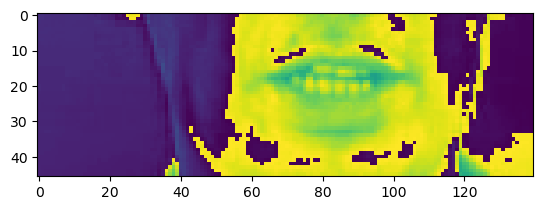

In [330]:
plt.imshow(frames[40])

In [331]:
tf.strings.reduce_join([bytes.decode(x) for x in num_to_char(alignments.numpy()).numpy()])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue at l six now'>

In [332]:
def mappable_function(path:str) ->List[str]:
    result = tf.py_function(load_data, [path], (tf.float32, tf.int64))
    return result

In [333]:
data = tf.data.Dataset.list_files('./data/s1/*.mpg')
data = data.shuffle(500, reshuffle_each_iteration=False)
data = data.map(mappable_function)
data = data.padded_batch(2, padded_shapes=([75,None,None,None],[40]))
data = data.prefetch(tf.data.AUTOTUNE)

train = data.take(450)
test = data.skip(450)

In [334]:
frames, alignemnts = data.as_numpy_iterator().next()

In [335]:
len(frames)

2

In [336]:
test = data.as_numpy_iterator()

In [337]:
val = test.next(); val[0]

array([[[[[1.4173921 ],
          [1.3810487 ],
          [1.4173921 ],
          ...,
          [0.3270905 ],
          [0.36343387],
          [0.36343387]],

         [[1.4537355 ],
          [1.3810487 ],
          [1.4173921 ],
          ...,
          [0.3270905 ],
          [0.36343387],
          [0.36343387]],

         [[1.4900789 ],
          [1.4900789 ],
          [1.4173921 ],
          ...,
          [0.39977726],
          [0.2907471 ],
          [0.2907471 ]],

         ...,

         [[1.0539583 ],
          [1.0539583 ],
          [1.0539583 ],
          ...,
          [0.10903016],
          [0.10903016],
          [0.10903016]],

         [[1.0539583 ],
          [1.0539583 ],
          [1.0539583 ],
          ...,
          [0.10903016],
          [0.10903016],
          [0.10903016]],

         [[1.0539583 ],
          [1.0539583 ],
          [1.0539583 ],
          ...,
          [0.10903016],
          [0.10903016],
          [0.07268678]]],


        [[[1.4537

In [338]:
imageio.mimsave('./animation.gif',val[0][0],fps=10)

Lossy conversion from float32 to uint8. Range [0.0, 9.267563819885254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.267563819885254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.267563819885254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.267563819885254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.267563819885254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.267563819885254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0.0, 9.267563819885254]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. R

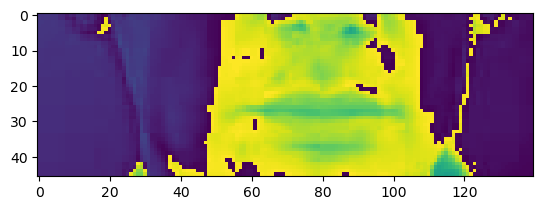

In [339]:
plt.imshow(val[0][0][0])

In [340]:
tf.strings.reduce_join([num_to_char(word) for word in val[1][0]])

<tf.Tensor: shape=(), dtype=string, numpy=b'bin blue in e nine soon'>

In [341]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv3D, LSTM, Dense, Dropout, Bidirectional, MaxPool3D, Activation, Reshape, SpatialDropout3D, BatchNormalization, TimeDistributed, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler

In [342]:
model = Sequential()
model.add(Conv3D(128, 3, input_shape=(75,46,140,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(256, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(Conv3D(75, 3, padding='same'))
model.add(Activation('relu'))
model.add(MaxPool3D((1,2,2)))

model.add(TimeDistributed(Flatten()))

model.add(Bidirectional(LSTM(128, kernel_initializer="Orthogonal", return_sequences=True)))
model.add(Dropout(.5))

model.add(Bidirectional(LSTM(128, kernel_initializer="Orthogonal", return_sequences=True)))
model.add(Dropout(.5))

model.add(Dense(char_to_num.vocabulary_size()+1, kernel_initializer='he_normal', activation='softmax'))

In [343]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_15 (Conv3D)          (None, 75, 46, 140, 128)  3584      
                                                                 
 activation_15 (Activation)  (None, 75, 46, 140, 128)  0         
                                                                 
 max_pooling3d_15 (MaxPoolin  (None, 75, 23, 70, 128)  0         
 g3D)                                                            
                                                                 
 conv3d_16 (Conv3D)          (None, 75, 23, 70, 256)   884992    
                                                                 
 activation_16 (Activation)  (None, 75, 23, 70, 256)   0         
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 75, 11, 35, 256)  0         
 g3D)                                                 

In [344]:
yhat = model.predict(val[0])

1/1 [==============================] - 3s 3s/step


In [345]:
tf.strings.reduce_join([num_to_char(tf.argmax(x)) for x in yhat[1]])

<tf.Tensor: shape=(), dtype=string, numpy=b'gg????????????????????????????????????????????????????????????????????????m'>

In [346]:
model.input_shape

(None, 75, 46, 140, 1)

In [347]:
model.output_shape

(None, 75, 41)

In [348]:
def scheduler(epoch, lr):
    if epoch < 30:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

In [349]:
def CTCLoss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = tf.keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [350]:
class ProduceExample(tf.keras.callbacks.Callback):
    def __init__(self, dataset) -> None:
        self.dataset = iter(dataset)

    def on_epoch_end(self, epoch, logs=None) -> None:
        data = next(self.dataset)
        yhat = self.model.predict(data[0])
        decoded = tf.keras.backend.ctc_decode(yhat, [75, 75], greedy=False)[0][0].numpy()
        for x in range(len(yhat)):
            print('Original:', tf.strings.reduce_join(num_to_char(data[1][x])).numpy().decode('utf-8'))
            print('Prediction:', tf.strings.reduce_join(num_to_char(decoded[x])).numpy().decode('utf-8'))
            print('~' * 100)

In [351]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss=CTCLoss)

In [352]:
checkpoint_callback = ModelCheckpoint(os.path.join('models','checkpoint'), monitor='loss', save_weights_only=True) 

In [353]:
schedule_callback = LearningRateScheduler(scheduler)

In [354]:
example_callback = ProduceExample(test)

In [355]:
model.fit(train, validation_data=test, epochs=100, callbacks=[checkpoint_callback, schedule_callback, example_callback])

Epoch 1/100
  1/450 [..............................] - ETA: 3:12:41 - loss: 219.3571

KeyboardInterrupt: 

# Predictions / Testing

In [356]:
url = 'https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y'
output = 'checkpoints.zip'
gdown.download(url, output, quiet=False)
gdown.extractall('checkpoints.zip', 'models')

Downloading...
From (uriginal): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y
From (redirected): https://drive.google.com/uc?id=1vWscXs4Vt0a_1IH1-ct2TCgXAZT-N3_Y&confirm=t&uuid=8a3ec1dd-c2fa-43a2-a2aa-44264f6b826f
To: /Users/daniel/checkpoints.zip
100%|██████████████████████████████████████| 94.5M/94.5M [00:21<00:00, 4.35MB/s]


['models/checkpoint.index',
 'models/__MACOSX/._checkpoint.index',
 'models/checkpoint.data-00000-of-00001',
 'models/__MACOSX/._checkpoint.data-00000-of-00001',
 'models/checkpoint',
 'models/__MACOSX/._checkpoint']

In [357]:
checkpoint = tf.train.Checkpoint(model=model)
checkpoint.restore('models/checkpoint')

for variable in model.trainable_variables:
    print(variable.name, variable.shape)

conv3d_15/kernel:0 (3, 3, 3, 1, 128)
conv3d_15/bias:0 (128,)
conv3d_16/kernel:0 (3, 3, 3, 128, 256)
conv3d_16/bias:0 (256,)
conv3d_17/kernel:0 (3, 3, 3, 256, 75)
conv3d_17/bias:0 (75,)
bidirectional_10/forward_lstm_10/lstm_cell_31/kernel:0 (6375, 512)
bidirectional_10/forward_lstm_10/lstm_cell_31/recurrent_kernel:0 (128, 512)
bidirectional_10/forward_lstm_10/lstm_cell_31/bias:0 (512,)
bidirectional_10/backward_lstm_10/lstm_cell_32/kernel:0 (6375, 512)
bidirectional_10/backward_lstm_10/lstm_cell_32/recurrent_kernel:0 (128, 512)
bidirectional_10/backward_lstm_10/lstm_cell_32/bias:0 (512,)
bidirectional_11/forward_lstm_11/lstm_cell_34/kernel:0 (256, 512)
bidirectional_11/forward_lstm_11/lstm_cell_34/recurrent_kernel:0 (128, 512)
bidirectional_11/forward_lstm_11/lstm_cell_34/bias:0 (512,)
bidirectional_11/backward_lstm_11/lstm_cell_35/kernel:0 (256, 512)
bidirectional_11/backward_lstm_11/lstm_cell_35/recurrent_kernel:0 (128, 512)
bidirectional_11/backward_lstm_11/lstm_cell_35/bias:0 (512,)

In [358]:
model.load_weights('models/checkpoint')

In [365]:
test_data = iter(test)

In [366]:
sample = test_data.next()

In [367]:
yhat = model.predict(sample[0])

1/1 [==============================] - 3s 3s/step


In [368]:
decoded = tf.keras.backend.ctc_decode(yhat, input_length=[75,75], greedy=True)[0][0].numpy()

In [369]:
print('~'*100, 'REAL TEXT')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in sample[1]]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ REAL TEXT


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green by u three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set white at i three again'>]

In [370]:
print('~'*100, 'PREDICTIONS')
[tf.strings.reduce_join([num_to_char(word) for word in sentence]) for sentence in decoded]

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ PREDICTIONS


[<tf.Tensor: shape=(), dtype=string, numpy=b'bin green by u three soon'>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'set white at i three again'>]